In [7]:
# Import Python Libraries
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns
import h5py
import pandas as pd
import netCDF4
import os
import subprocess
import scipy
import collections as col
import mpmath
import pdb
import copy

## Figures config
sns.set_style("whitegrid")
sns.set_context("notebook")
myblue = '#244c77ff'
mycyan = '#3f7f93ff'
myred ='#c3553aff'
myorange ='#f4a40bff'

## Config
confdir = os.getcwd()
## 3D or 2D test
is3d = True # or False

### Read and plot characteristics of inferred parameters

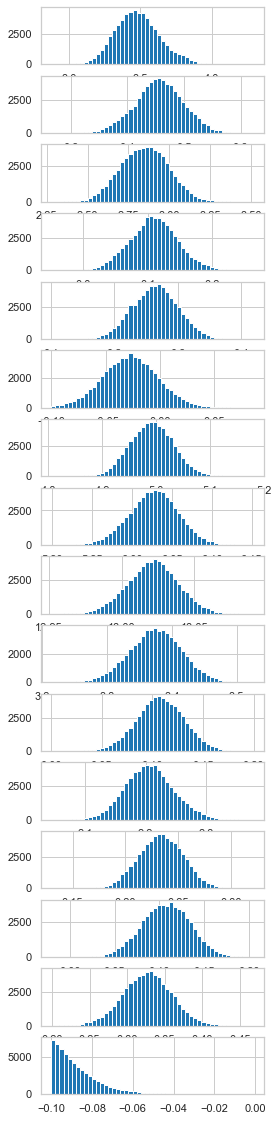

In [8]:
def calcM0(slip,area):
    '''
    in dyne.m
    
    mu S D *nbr subfaults * 10**7 to convert to dyn.cm
    '''
    mu = 2.5*1.e10
    
    # convert area to m2 (slip already in m)
    ssum = (slip[:]*area*1e6).sum()
    
    M0 = ssum * mu * 1.e7
    Mw = (2./3.)*np.log10(M0)-10.7

    return M0, Mw

## Read target
if is3d is True:
    init_trgt = np.loadtxt(confdir+'/3d_targetslip.txt', delimiter=',', comments='>')
    init_fault = np.loadtxt(confdir+'/3d_faultcenters.txt', delimiter=' ', comments='>')
    ind = np.where( np.logical_and(init_fault[:,1]>=-25, init_fault[:,1]<=10) )
    sel_fault = init_fault[ind,:]
    trgt = init_trgt[np.array(ind)+len(init_trgt)//2][0]
    area = np.loadtxt(confdir+'/3d_area.txt', delimiter=',', comments='>')[ind]
    Np = len(trgt)
    M0, Mw = calcM0(trgt,area)
    
    ## Read AlTar results
    h5file =  h5py.File(confdir+'/3d_res.h5','r')
    ss = h5file['ParameterSets']['strikeslip'][()][:,np.array(ind)]
    ds = h5file['ParameterSets']['dipslip'][()][:,np.array(ind)]
    slip = ds[:,0,:]
    Np = slip.shape[1]
    std = [np.std(slip[:,i]) for i in range(Np) ]
    moy = np.mean( slip, axis=0 )
    
    fig, ax = plt.subplots(Np,1,figsize=(4,20))
    for i in range(Np):
        ax[i].hist(slip[:,i], bins=50)
else:
    ini_trgt = np.loadtxt(confdir+'/2d_targetslip.dat', delimiter=',')
    trgt = np.array([np.average(ini_trgt[i:i+20,1]) for i in np.arange(0,200,20)] + np.zeros((10,)).tolist())
    area=2*50
    M0, Mw = calcM0(trgt[:10],area)

    ## Read AlTar results
    h5file =  h5py.File(confdir+'/2d_res.h5','r')
    ss = h5file['ParameterSets']['strikeslip'][()]
    ds = h5file['ParameterSets']['dipslip'][()]
    slip = ss
    samp = np.transpose(np.hstack((ss,ds)))
    Np= np.shape(samp)[0]//2  # number of subfaults
    std = [np.std(samp[i,:]) for i in range(Np) ]
    moy = np.mean( samp, axis=1 )

    ## Plot marginal posterior PDFs
    fig, ax = plt.subplots(10,1,figsize=(4,20))
    for i in range(10):
        ax[i].hist(slip[:,i], bins=50)

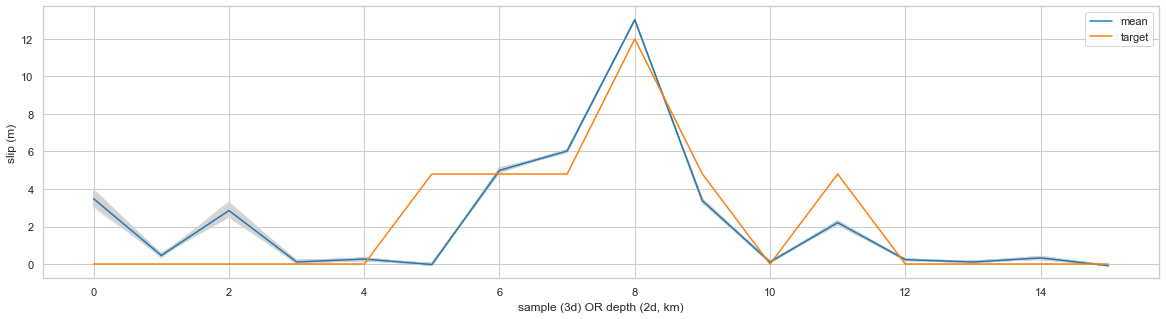

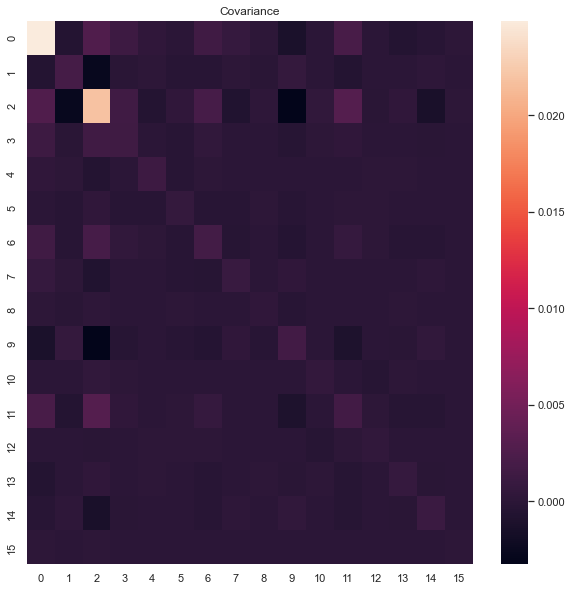

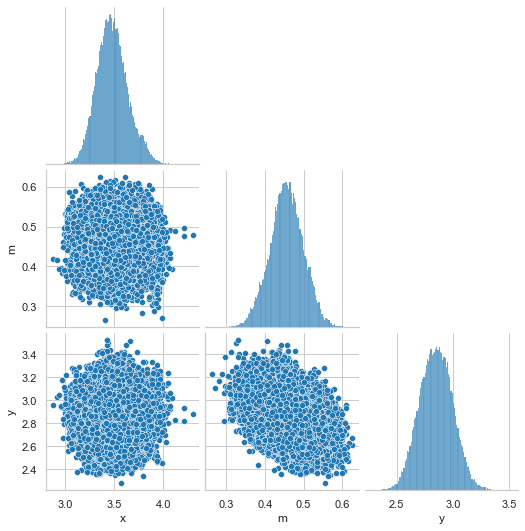

In [9]:
## Plot samples
fig, ax = plt.subplots(1,1,figsize=(20,5))
[plt.plot(slip[i,:], lw=0.5, c='lightgray') for i in range(slip.shape[0]-1000,slip.shape[0])]
plt.plot(moy, label='mean')
plt.plot(trgt, label='target')
plt.xlabel('sample (3d) OR depth (2d, km)')
plt.ylabel('slip (m)')
plt.legend()

## Plot Covariance
cov = np.cov(slip.T)
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(cov)
plt.title('Covariance')

## plot pairplot for 1st three params
sns.pairplot(pd.DataFrame({"x": slip.T[0], "m": slip.T[1], "y": slip.T[2]}), corner=True)


### Resample with semi-variogram

In [13]:
if is3d is False:
    Nsamp = 100000
    p = np.empty((Np,Nsamp))
    L = np.zeros((3,Np))
    L[2,:] = np.arange(1,20,2)

    for i in range(Np):
        n = np.random.randint(0,slip.shape[0],Nsamp)
        p[i] = slip[n,i]

    resamp=[]
    plt.figure()
    for i in range(Nsamp):
        Mw_samp = calcM0(p[:,i],area)[1]
        if (Mw-0.5<=Mw_samp and Mw_samp<=Mw+0.5):
            ## Calculate and plot Semivariogram
            m = np.array([[math.sqrt((L[0,k]-L[0,j])**2+(L[1,k]-L[1,j])**2+(L[2,k]-L[2,j])**2), p[k,i], p[j,i]] 
                                     for k in range(Np) for j in range(Np) if k>j])
            ii = np.argsort(m[:,0])
            dis = m[ii,0]
            dv = (m[ii,1] - m[ii,2])**2

            bins = np.arange(0., 25, 1)
            inds = np.digitize(dis, bins)

            distance = []
            covariogram = []
            std = []
            for l in range(len(bins)-1):
                uu = np.flatnonzero(inds==l)
                if len(uu)>0:
                    distance.append(bins[l] + (bins[l+1] - bins[l])/2.)
                    covariogram.append(0.5*np.max(dv[uu]))
                    std.append(np.std(dv[uu]))

            ## Select samples
            if np.amax(covariogram[0:1])< 0.8:
                Mw_samp = calcM0(p[:,i],area)[1]
                if (Mw-0.1<=Mw_samp and Mw_samp<=Mw+0.1):
                    plt.plot(distance, covariogram)
                    plt.title('Semivariogram for selected samples')
                    resamp.append(p[:,i])

    ## plot pairplot for 
    resamp=np.array(resamp)
    sns.pairplot(pd.DataFrame({"x": resamp.T[0], "m": resamp.T[1], "y": resamp.T[2]}), corner=True)
    
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    [plt.plot(resamp[i,:], lw=0.5, c='lightgray') for i in range(resamp.shape[0])]
    plt.plot(np.mean([resamp[i,:] for i in range(resamp.shape[0])], axis=0))
    plt.plot(moy[:10])
    plt.plot(trgt[:10])